## Preliminaries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns; sns.set(style="ticks", color_codes=True)

import geopandas as gpd
import descartes #important for integrating Shapely Geometry with the Matplotlib Library
import mapclassify #You will need this to implement a Choropleth
import geoplot

import re #we need this to do some string cleaning

%matplotlib inline

### Load Shapefiles

Download the shapefile and load it using geopandas. An important note here when extracting the zip package: all the contents should be in one folder, even though you will simply be using the ".shp" file or else it won't work. (this means that the ".cpg", ".dbf", ".prj" and so forth should be in the same location as your ".shp" file.

You can download the shapefile of the Philippines in gadm.org (https://gadm.org/)

In [2]:
#The level of adminsitrative boundaries are given by 0 to 3; the detail and boundaries get more detailed as the level increase

country = gpd.GeoDataFrame.from_file("Shapefiles/gadm36_PHL_shp/gadm36_PHL_0.shp")
provinces = gpd.GeoDataFrame.from_file("Shapefiles/gadm36_PHL_shp/gadm36_PHL_1.shp")
cities = gpd.GeoDataFrame.from_file("Shapefiles/gadm36_PHL_shp/gadm36_PHL_2.shp")
barangay = gpd.GeoDataFrame.from_file("Shapefiles/gadm36_PHL_shp/gadm36_PHL_3.shp")

At this point, you can view the shapefiles and examine the border that is appropriate to your intentions. You can do this by plotting the shapefiles

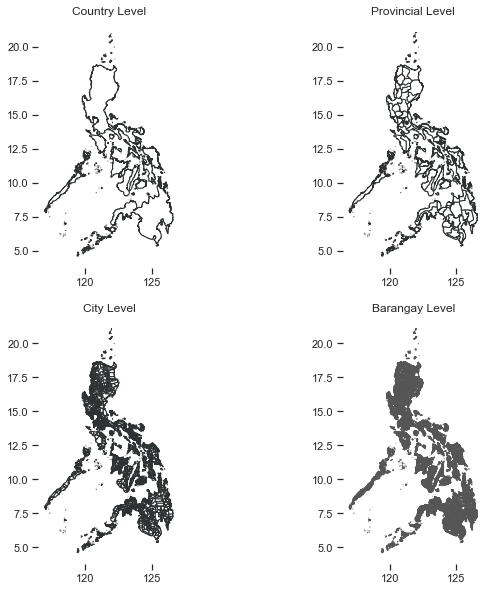

In [3]:
#the GeoDataFrame of pandas has built-in plot which we can use to view the shapefile

fig, axes = plt.subplots(2,2, figsize=(10,10));

#Color here refers to the fill-color of the graph while 
#edgecolor refers to the line colors (you can use words, hex values but not rgb and rgba)
country.plot(ax=axes[0][0], color='white', edgecolor = '#2e3131');
provinces.plot(ax=axes[0][1], color='white', edgecolor = '#2e3131');
cities.plot(ax=axes[1][0], color='white', edgecolor = '#2e3131');
barangay.plot(ax=axes[1][1], color='white', edgecolor = '#555555');

#Adm means administrative boundaries level - others refer to this as "political boundaries"
adm_lvl = ["Country Level", "Provincial Level", "City Level", "Barangay Level"]
i = 0
for ax in axes:
    for axx in ax:        
        axx.set_title(adm_lvl[i])
        i = i+1
        axx.spines['top'].set_visible(False)
        axx.spines['right'].set_visible(False)
        axx.spines['bottom'].set_visible(False)
        axx.spines['left'].set_visible(False)
        

### Load Population Density Data

Population Density and Population data are usually collected by the government. And the Philippines have been advancing on the provision of these data. (Good Job Philippines!).

Since population is taken every five (5 years), the latest as of this writing is the 2015 Census Data.

We first load the data and examine it:

In [4]:
df = pd.read_excel(r'data\2015 Population Density.xlsx',
                  header=1,
                  skipfooter=25,
                   usecols='A,B,D,E',
                  names=["City", 'Population', "landArea_sqkms", "Density_sqkms"])

### Cleaning the data

Before we can proceed with the processing, we have to clean our data. We should:

  *  drop rows with empty values
  *  remove non-alphabet characters in names
  *  remove the words (capital) after each city name
  *  remove leading and trailing spaces
  *  add "excluding [x]" back to main city
  *  and many more....

Cleaning really will take bulk of the work when merging data with shapefiles. This is true for Philippines, which have cities that are named similarly after one another. (e.g. San Juan, San Pedro, etc)

In [5]:
#Removing unwanted characters
df=df.replace('\*','',regex=True)
df.City=df.City.str.replace('[0-9]','',regex=True)
df.City=df.City.str.replace('\(.*?\)','',regex=True)

#Removing "City of"
df['City'] = df['City'].str.replace(r'City of ', '')

#Removing "Municipality of"
df['City'] = df['City'].str.replace(r'Municipality of ', '')

#Removing Niño character
df['City'] = df['City'].str.replace(r'Niño', 'Nino')

df['City'] = df['City'].str.replace(r'\(Capital of Basilan\)', 'Capital')

#Removing Whitespace
df['City'] = df['City'].str.strip()
df.City = df.City.replace('',np.nan)
df = df.dropna(how="any")


In [6]:
#At this point, we should add the individual changes to clean cities with shapefiles
# Create a list using which we will use to remap the values  

#Name in the DF file
df_name = ['Makati','Cabadbaran', 'Bayugan', 'Taguig City', 'Caloocan City', 'Pasig','Ligao' ] 

#Name in the Cities File
cities_name = ['Makati City','Cabadbaran City', 'Bayugan City','Taguig',"Kalookan City","Pasig City", "Ligao City"]

#Create a loop to check recurring items
for i in range(len(df_name)):
    df.City = df.City.str.replace(df_name[i],cities_name[i])

We can likewise do a scatter plot, just to see which cities have high densities in chart form. Matplotlib is workable but I like the style of seaborn plots so I use it for everything.

In [7]:
#First sort the dataframe according to Density from highest to lowest
sorted_df = df.sort_values("Density_sqkms", ascending=False,ignore_index=True )[:50]

500

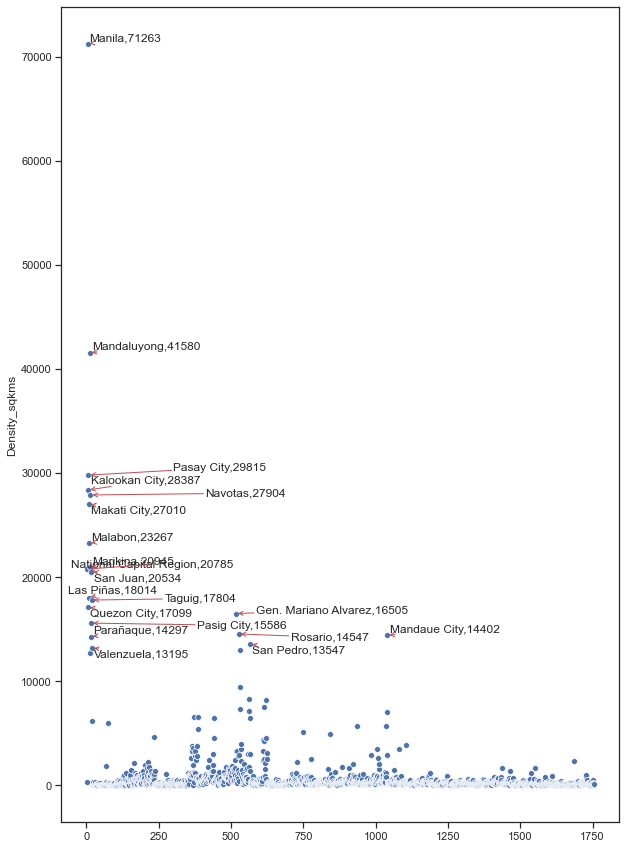

In [8]:
fig, ax = plt.subplots(figsize=(10,15));
scatter = sns.scatterplot(x=df.index, y=df.Density_sqkms)

#Labeling the top 20 data (limiting so it won't get too cluttered)
#First sort the dataframe according to Density from highest to lowest
sorted_df = df.sort_values("Density_sqkms", ascending=False)[:20]


#Since text annotations,overlap for something like this, let's import a library that adjusts this automatically 
from adjustText import adjust_text

texts = [ax.text(p[0], p[1],"{},{}".format(sorted_df.City.loc[p[0]], round(p[1])),
          size='large') for p in zip(sorted_df.index, sorted_df.Density_sqkms)];

adjust_text(texts, arrowprops=dict(arrowstyle="->", color='r', lw=1), precision=0.01)

With this chart, we can already see which cities are above the average of "Nationa Capital Region", namely, Mandaluyong, Pasay, Caloocan, Navotas, Makati, Malabon and Marikina.

Within the top 20 as well, we can see that most of these cities are located in the "National Capital Region" and nearby provinces such as Laguna. Notice as well how the city of Manila is an outlier for this dataset.

### Merging the DataFrames

In [9]:
#Counting City Names that doubled and excludes them from the creation of merged dataframe.
#The plan is to attach unique IDs to the municipality/city names so that we can merge them easily


#Creates a list of repeating names for PSA
x= pd.DataFrame(df.City.value_counts()).reset_index().sort_values(['City', 'index'], ascending=[False, True])
x = x[x.City != 1]['index'].to_list()


#When creating an initial merged DataFrame, we need to remove those that tends to repeat so we can manually assign the IDs
unique_df = df[~df.City.isin(x)]
len(unique_df)

1357

In [10]:
print(len(x))
pd.Series(x).to_csv("RepeatedCities.csv") 

129


Now that we have a unique DataFrame, we can combine those that have no duplicates and we should use "outer" join to do it. Outer join keeps all the elements of the dataframes so that we can edit them in the future.

In [11]:
merged_df = unique_df.merge(cities, left_on="City", right_on="NAME_2", how="outer")
merged_df.shape

#Cities that does not have df
print("Cities that do not have statistical info: ",len(merged_df[merged_df.City.isna()]))

#Population Data that does not have GADM data
print("Population data that does not have GADM (shapefile) data: ", len(merged_df[merged_df.NAME_2.isna()]))

Cities that do not have statistical info:  457
Population data that does not have GADM (shapefile) data:  169


At this point, we can start to add in unique info for this unique_df which we will use to tie two tables (population data and density) together.

In [12]:
i = 98

#amended_cities
#Creating this to remove the "city" from Cities table
amended_cities = cities.copy()
amended_cities.NAME_2 = amended_cities.NAME_2.str.replace("City","").str.strip()
amended_cities.NAME_2 = amended_cities.NAME_2.str.replace(r'Niño', 'Nino').str.strip()

display(amended_cities[amended_cities.NAME_2==x[i]][["NAME_1", "NAME_2"]].reset_index(drop=True));
print("Length: ", len(amended_cities[amended_cities.NAME_2==x[i]][["NAME_1", "NAME_2"]].reset_index(drop=True)))
print('---------------------------------------------')
display(df[df.City==x[i]])
print("Length: ", len(df[df.City==x[i]]))

,NAME_1,NAME_2


Length:  0
---------------------------------------------


,City,Population,landArea_sqkms,Density_sqkms
235,San Carlos City,188571.0,169.03,1115.606697
1077,San Carlos City,132536.0,451.5,293.545958


Length:  2


In [13]:
#This will need to be done manually as their is no way to identify them
psa_stat_index=[
    [0,4,7,1,5,6,2,3,8], #San Isidro, 0
    [8,1,6,7,2,0,4,5,3], #San Jose, 1
    [1,0,3,2,np.nan,4,5,6], #Rizal, 2
    [0,1,5,3,2,4,6], #Pilar, #3
    [1,4,3,np.nan,6,5, 0], #Quezon, 4
    [3,5,6,1,4,2,0], #San Fernando, #5
    [4,0,2,3,1,5,6], #San Juan, #6    
    [1,2,3,0,4,6,5], #San Miguel,7
    [2,5,3,0,4,6,1], #Santa Maria, #8
    [0,1,3,4,2,5], #Burgos, 9
    [1,2,3,4,0,5], # Carmen, 10
    [1,5,2,3,4,0], #Santa Cruz, 11
    [3,5,2,4,0,1], #Santo Tomas, 12
    [4,3,2,1,0], #Buenavista, 13
    [3,4,1,2,0], #Magsaysay, 14
    [3,1,2,4,0], #Rosario, 15
    [2,1,3,0,4], #San Francisco, 16
    [3,2,0,1], #Concepcion, 17
    [0,3,2,1], #La Paz, 18
    [3,0,1,2], #Mabini, 19
    [1,3,2,0], #San Antonio, 20
    [1,3,2,0], #San Luis, 21
    [1,3,0,2], #San Vicente, 22
    [2,3,0,1], #Santa Fe, 23
    [0,1,2,3], #Talisay, 24
    [3,0,2,1], #Victoria, 25
    [1,0,2], #Alicia, 26
    [0,np.nan, 1], #Aurora, 27
    [0,1,2], #Bato, 28
    [0,1,2], #Claveria, 29
    [0,2,1], #Dolores, 30
    [1,2,0], #Esperanza 31
    [np.nan, 1,0], #Isabela 32
    [0,2,1], #Luna 33
    [1,2,0], #Magallanes, 34
    [0,1,2], #Pamplona 35
    [0,2,1], #Plaridel, 36
    [0,1, np.nan], #Quirino, 37
    [1,2,0], #Roxas, 38
    [0,1,2], #San Agustin, 39
    [1,2,0], #San Andres 40
    [1,0,2], #San Manuel, 41
    [1,2,0], #San Nicolas, 42
    [1,2,0], #Santiago, 43
    [1,2,0], #Santo Domingo, 44
    [0,1,2], #Santo Nino, 45
    [0,2,1], #Valencia, 46
    [1,0], #Alaminos, 47
    [1,0], #Alcala, 48
    [1,0], #Alcantara, 49
    [0,1], #Alegria, 50
    [1,0], #Anda, 51
    [1,0], #Balete, 52
    [0,1], #Banga, 53
    [1,0], #Baras, 54
    [1,0], #Batuan, 55
    [np.nan, 0], #Biliran 56
    [0,1], #Bontoc, 57
    [np.nan, 0], #Bulacan, 58
    [1,0], #Cabatuan, 59
    [0,1],#Calamba, 60
    [1,0], #Calatrava 61
    [1,0], #Candelaria 62
    [0,1], #Casiguran 63
    [1,0], #Catarman, 64
    [0,1],# Cauayan, 65
    [0,1], #Clarin, 66
    [0,1], #Compostella, 67
    [0,1], #Cortes, 68
    [0,1], #General Luna 69
    [0,1], #Hagonoy, 70
    [0,1], #Infanta, 71
    [np.nan,1], #sabela, 72
    [0,np.nan], #Kalayaan, 73
    [0,1], #Kapatagan, 74
    [0,1], #La Libertad, 75 
    [0,1], #lemery 76
    [0,1], #Libertad 77
    [0,1], #Liloan, 78
    [0,1], #Looc 79
    [0,1], #Loreto, 80
    [0,1], #Maasin #81
    [1,0], #Malinao 82
    [1,0], #Maltibog 83
    [np.nan, 0], #Masbate, 84
    [0,1], #Mercedes, 85
    [0,1],#Morong, 86
    [1,2], #Naga, 87
    [1,0], # Naguilan 88
    [0,1], #Padre Burgos 89
    [1,0], #Pandan 90
    [0,1], #Parang, 91
    [0,1], #Pitogo, 92
    [0,1], #Placer, 93
    [0,1], #Pontevedra 94
    [0,1], #President Roxas 95
    [np.nan, 0], #Romblon 96
    [1,0], #Salcedo 97
    [np.nan,np.nan], #San Carlos 98
    [0,1], #San Enrique 99
    [1,0], #San Idelfonso 100
    [1,0], #San Jacinto, 101
    [0,1], #San Mateo, 102
    [1,0], #San Narciso, 103
    [0,2], #San Pablo, 104 
    [0,1], #San Pascual, 105
    [0,1], #San Quintin, 106
    [0,1], #San Rafael. 107
    [0,1], #San Remigio, 108
    [0,1], #Santa Ana,109
    [1,0], #Santa Barbara, 110
    [0,1], #Santa Catalina, 111
    [0,1], #Santa Rita, 112
    [1,0], #Santa Rosa, 113
    [1,0], #Santa Teresita, 114
    [0, np.nan], #Sarangani, 115
    [np.nan, 1], #Siquijor, 116
    [0,1], #Sison 117
    [0,1], #Socorro 118
    [0,1], #Sogod 119
    [np.nan, 0], #Sorsogon 120
    [np.nan, 0], #Sultan Kudarat 121   
    [0,1], #Tagoloan, 122
    [0,1], #Tanauan, 123
    [np.nan, 0], #Tarlac 124
    [1,0], #Taytay 125
    [0,1], #Tubod 126
    [1,0], #Tuburan 127
    [0,1], #Tudela, 128
]

# LOOP TO APPEND THE DFS USING PSA INDICES
#After this, append the dfs to unique_df

from tqdm import tqdm

dfs = []
for i in tqdm(range(len(psa_stat_index))):
    dft = df[df.City==x[i]].set_index([psa_stat_index[i]]).merge((cities[cities.NAME_2==x[i]]).reset_index(drop=True), right_index=True, left_index=True)
    dfs.append(dft)


100%|████████████████████████████████████████████████████████████████████████████████| 129/129 [00:01<00:00, 78.99it/s]


In [14]:
### After attaching the relevant IDs, append to the individual dfs to the merged_df (where unique cities have been placed)
for table in dfs:
    merged_df = pd.concat([merged_df, table])

In [15]:
merged_df = merged_df.drop_duplicates(subset=["CC_2"], keep="last")

print("Cities that do not have statistical info: ",len(merged_df[merged_df.City.isna()]))

Cities that do not have statistical info:  107


### Possible Strategy to merge remaining data:

  *  Create a list of indexes that we can identify and add a column of CC_2 for the statistic table
  *  Create a new dataframe from merged_df where those with empty City are excluded

In [16]:
print("Number of unique population entries: ", df.Population.nunique())
print("Number of unique density entries: ", df.Density_sqkms.nunique())
print("Number of entries in merged dataframe: ", len(merged_df))
print("Number of entries in stastical dataframe: ", len(df))

Number of unique population entries:  1720
Number of unique density entries:  1732
Number of entries in merged dataframe:  1629
Number of entries in stastical dataframe:  1732


### There seems to be some common reasons why simple merge does not work on the two dataframes

  *  One df has the word city and the other does not
  *  One df has lower case and the other has an upper on a hyphened word

#### Cleaning cities that does not have statistical info

In [17]:
#We will be playing with these column names as indexers so better separate them
geo_df_cols = cities.columns.to_list()
unmatched_df_columns = merged_df.columns.to_list()

# #Create a dataframe where we will append our merged data
unmatched_df = pd.DataFrame(columns=unmatched_df_columns)


In [18]:
def clean_stat_and_geo_dataframes(merged_df):
    #Create a dataframe where we will append our merged data
    unmatched_df = pd.DataFrame(columns=unmatched_df_columns)
    
    #Creating a unique density list to separate unmatched ones
    densities = merged_df["Density_sqkms"].reset_index(drop=True).to_list()
    unmatched_index = [] 

    for i in range(len(df)):
        if df.iat[i,3] not in densities: #Check if the density reported in stat is in merged_df
            unmatched_index.append(i)

    unmatched_stat = df.iloc[unmatched_index].reset_index(drop=True)

    unmatched_geo_df = merged_df[merged_df.City.isna()].reset_index(drop=True)[geo_df_cols]
    # unmatched_geo_df = unmatched_geo_df[geo_df_cols]

    #Create Unique Cities list count
    #We need to get only unique data or else we will have duplicate entries
    city_count = pd.DataFrame(unmatched_stat.City.value_counts())
    cities_list = city_count[city_count.City == 1].reset_index()["index"].str.lower().to_list()
    geo_df_count = pd.DataFrame(unmatched_geo_df.NAME_2.value_counts())
    geo_df_cities_list = geo_df_count[geo_df_count.NAME_2 == 1].reset_index()["index"].str.lower().to_list()
    return unmatched_geo_df, unmatched_stat, geo_df_cities_list, cities_list, merged_df

def merge_and_clean(merged_df, unmatched_df):
    print("Initializing merge and clean algorithm")
    print("<>-------<>-------<>-------<>-------<>-------<>")
    print("")
    print("Unmatched dataframe has {} entries".format(len(unmatched_df)))
    merged_df = pd.concat([merged_df, unmatched_df])
    merged_df = merged_df.drop_duplicates(subset=["CC_2"], keep="last")
    print("<>-------<>-------<>-------<>-------<>-------<>")
    print("Cities that do not have statistical info: ",len(merged_df[merged_df.City.isna()]))
    print("")
    return clean_stat_and_geo_dataframes(merged_df)
    
#Let's try merging on the condition that the lower casings are ignored

unmatched_geo_df, unmatched_stat, geo_df_cities_list, cities_list, merged_df = clean_stat_and_geo_dataframes(merged_df)

for i in range(len(unmatched_geo_df)):
    if unmatched_geo_df.iloc[i].NAME_2.lower() in cities_list:
        a = unmatched_geo_df.iloc[i].to_list()
        name = unmatched_geo_df.iloc[i].NAME_2.lower()
        b = unmatched_stat[unmatched_stat.City.str.lower().str.contains(name)].iloc[0].to_list()
        c = b+a
        unmatched_df.loc[len(unmatched_df)] = c
print("Unmatched dataframe has {} entries".format(len(unmatched_df)))
print("Cities that do not have statistical info: ",len(merged_df[merged_df.City.isna()]))

#Matching similar cities where the geo_df lacks the word "city"
unmatched_geo_df, unmatched_stat, geo_df_cities_list, cities_list, merged_df = merge_and_clean(merged_df, unmatched_df)

for i in range(len(unmatched_geo_df)):
    if unmatched_geo_df.iloc[i].NAME_2.lower() + " city" in cities_list:
        a = unmatched_geo_df.iloc[i].to_list()
        name = unmatched_geo_df.iloc[i].NAME_2.lower()
        b = unmatched_stat[unmatched_stat.City.str.lower().str.contains(name)].iloc[0].to_list()
        c = b+a
        unmatched_df.loc[len(unmatched_df)] = c
print("Unmatched dataframe has {} entries".format(len(unmatched_df)))
print("Cities that do not have statistical info: ",len(merged_df[merged_df.City.isna()]))

#Matching similar cities where the stat table lacks the word "city"
unmatched_geo_df, unmatched_stat, geo_df_cities_list, cities_list, merged_df = merge_and_clean(merged_df, unmatched_df)

for i in range(len(unmatched_stat)):
    if unmatched_stat.iloc[i].City.lower() + " city" in geo_df_cities_list:
        a = unmatched_stat.iloc[i].to_list()
        name = unmatched_stat.iloc[i].City.lower() + " city"
        b = unmatched_geo_df[unmatched_geo_df.NAME_2.str.lower().str.contains(name)].iloc[0].to_list()
        c = a+b
        unmatched_df.loc[len(unmatched_df)] = c
unmatched_geo_df, unmatched_stat, geo_df_cities_list, cities_list, merged_df = merge_and_clean(merged_df, unmatched_df)

Unmatched dataframe has 21 entries
Cities that do not have statistical info:  107
Initializing merge and clean algorithm
<>-------<>-------<>-------<>-------<>-------<>

Unmatched dataframe has 21 entries
<>-------<>-------<>-------<>-------<>-------<>
Cities that do not have statistical info:  86

Unmatched dataframe has 26 entries
Cities that do not have statistical info:  86
Initializing merge and clean algorithm
<>-------<>-------<>-------<>-------<>-------<>

Unmatched dataframe has 26 entries
<>-------<>-------<>-------<>-------<>-------<>
Cities that do not have statistical info:  81

Initializing merge and clean algorithm
<>-------<>-------<>-------<>-------<>-------<>

Unmatched dataframe has 81 entries
<>-------<>-------<>-------<>-------<>-------<>
Cities that do not have statistical info:  31



In [19]:
unmatched_geo_df = unmatched_geo_df.sort_values(by=["NAME_2", "NAME_1"], ascending=[True, True]).reset_index(drop=True)
unmatched_geo_df

,GID_0,NAME_0,GID_1,NAME_1,NL_NAME_1,GID_2,NAME_2,VARNAME_2,NL_NAME_2,TYPE_2,ENGTYPE_2,CC_2,HASC_2,geometry
0,PHL,Philippines,PHL.15_1,Bohol,None,PHL.15.1_1,Albuquerque,Alburquerque,None,Bayan|Munisipyo,Municipality,71201,PH.BO.AB,"POLYGON ((123.95467377 9.60758972, 123.9544372..."
1,PHL,Philippines,PHL.42_1,Lanao del Sur,None,PHL.42.1_1,Bacolod Kalawi,Bacolod-Kalawi (Bacolod Grande),None,Bayan|Munisipyo,Municipality,153601,PH.LS.BC,"(POLYGON ((124.13725281 7.85604, 124.13626862 ..."
2,PHL,Philippines,PHL.37_1,Isabela,None,PHL.37.8_1,Cauayan City,None,None,Lungsod|Siyudad,City,23108,PH.IB.CU,"POLYGON ((121.80235291 16.83415985, 121.802543..."
3,PHL,Philippines,PHL.25_1,Cebu,None,PHL.25.20_1,Cordoba,None,None,Bayan|Munisipyo,Municipality,72220,PH.CB.CO,"(POLYGON ((123.99128723 10.20582962, 123.99157..."
4,PHL,Philippines,PHL.44_1,Maguindanao,None,PHL.44.7_1,Datu Abdullah Sanki,None,None,Bayan|Munisipyo,Municipality,153828,None,"POLYGON ((124.51439667 6.72666979, 124.5108871..."
5,PHL,Philippines,PHL.36_1,Iloilo,None,PHL.36.16_1,Duenas,Dueñas,None,Bayan|Munisipyo,Municipality,63017,PH.II.DE,"POLYGON ((122.59311676 10.99773979, 122.591712..."
6,PHL,Philippines,PHL.24_1,Cavite,None,PHL.24.8_1,General Mariano Alvarez,None,None,Bayan|Munisipyo,Municipality,42123,PH.CV.GL,"POLYGON ((121.00055695 14.27995014, 120.998016..."
7,PHL,Philippines,PHL.15_1,Bohol,None,PHL.15.27_1,Jetafe,None,None,Bayan|Munisipyo,Municipality,71226,PH.BO.JT,"(POLYGON ((124.08110809 10.17778015, 124.08110..."
8,PHL,Philippines,PHL.40_1,Laguna,None,PHL.40.9_1,Kalayaan,None,None,Bayan|Munisipyo,Municipality,43409,PH.LG.KL,"POLYGON ((121.48301697 14.31626034, 121.482009..."
9,PHL,Philippines,PHL.80_1,Zamboanga del Sur,None,PHL.80.11_1,Lakewood Lake,None,None,Waterbody,Waterbody,0,None,"POLYGON ((123.15409088 7.8333602, 123.15350342..."


In [20]:
#Create index to merge with unmatched_geo_df
unmatched_stat_index = [
    np.nan, #Albaquerque
    125, #Bacolod-Kalawi,
    np.nan, #Cauayan
    np.nan, #Cordoba
    128, #Datu Abdullah Sanki
    np.nan, #Duenas
    37, #Gen. Mariano Alvarez,
    np.nan, #Jetafe
    40, #Kalayaan,
    np.nan, #Lakewood Lake
    126, #Lumbaca-Unayan,
    35, #Mataas na Kahoy,
    38, #Mendez,
    28, #Muñoz
    95, #Naga
    np.nan, #Paoay
    91, #Piñan
    14, #Pozurrubio
    np.nan, #Quezon
    57, #Sagnay
    105, #Island City of Samal
    80, #San Carlos City
    15, #San Carlos City
    52, #San Fernando La Union
    30, #San Fernando - Pampanga,
    112, #Santo Nino
    92, #Sergio
    77, #Siquijor
    50, #Sofronio Espanola
    75, #Talisay
    81, #Talisay
]

In [21]:
# unmatched_stat[unmatched_stat.Population == 20374]
merged_df[merged_df.Population == 104116]

,City,Population,landArea_sqkms,Density_sqkms,GID_0,NAME_0,GID_1,NAME_1,NL_NAME_1,GID_2,NAME_2,VARNAME_2,NL_NAME_2,TYPE_2,ENGTYPE_2,CC_2,HASC_2,geometry
0,Quezon,104116.0,626.86,166.091312,PHL,Philippines,PHL.16_1,Bukidnon,None,PHL.16.18_1,Quezon,None,None,Bayan|Munisipyo,Municipality,101317,PH.BK.QE,"POLYGON ((125.18409729 7.60171986, 125.1534500..."


In [22]:
#Merge remaining stat data
unmatched_df = unmatched_stat.merge(unmatched_geo_df.set_index([unmatched_stat_index]),left_index=True, right_index=True)

In [23]:
#Merged with the merged DF
merged_df = pd.concat([merged_df, unmatched_df])
merged_df = merged_df.drop_duplicates(subset=["CC_2"], keep="last")

merged_df = merged_df.drop_duplicates(subset=["Density_sqkms"],keep="last")

merged_df = gpd.GeoDataFrame(merged_df, crs="EPSG:4326")
# merged_df = merged_df.reset_index(drop=True)

len(merged_df)

1621

At this point, the unmatched geodataframe rows are simply duplicates and we have successfully cleaned our data!

# Visualization
At this point, we can already visualize our data using the builtin plot method of GeoPandas.

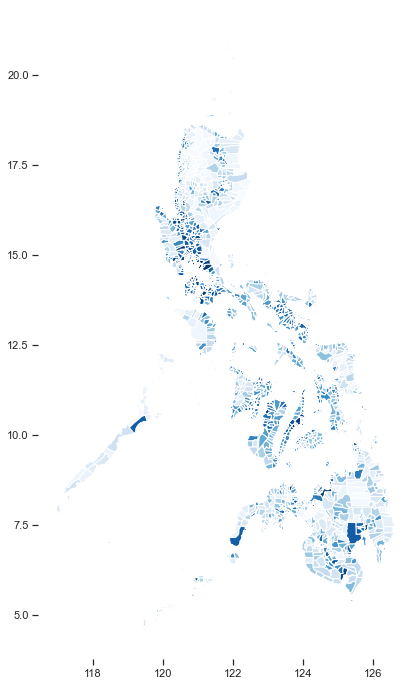

In [24]:
import mapclassify
colors = 1600
cmap = 'Blues'
figsize=(12,12)
scheme= 'Quantiles'

ax = merged_df.plot(column='Density_sqkms', cmap=cmap, figsize=figsize,
                          scheme=scheme, k=colors, legend=False)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

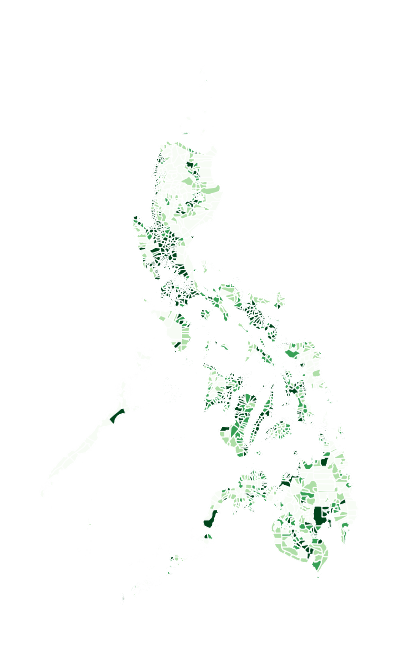

In [48]:
import geoplot

colors = 500
cmap = 'Greens'
figsize=(12,12)
scheme= 'Quantiles'

geoplot.choropleth(
    merged, hue=merged.Density_sqkms, scheme=scheme,
    cmap=cmap, figsize=figsize
)

In [34]:
merged = merged_df.copy()
merged = merged.reset_index(drop=True)

In [39]:
merged_df.index

Int64Index([  2,   3,   4,   5,   6,   7,   8,   9,  10,  11,
            ...
             80,  81,  91,  92,  95, 105, 112, 125, 126, 128],
           dtype='int64', length=1621)

In [ ]:
merged_df.Density_sqkms.value_counts()

In [38]:
len(merged)

1621

In [40]:
len(cities)

1647